<a href="https://colab.research.google.com/github/DipeshChothwe/NLP/blob/master/Classifying_Emails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHgBJzmf3Qk9BZcuMNHwRpl3NlNOxSJUeaoNA0j3aR69DX8nsu-eO4
Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
import time
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
msg = pd.read_csv("/content/drive/My Drive/NLP/messages.csv")

In [4]:
msg.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [5]:
print("length of data: ", len(msg))
print("missing values from msg:")
print(msg.isnull().sum())


length of data:  2893
missing values from msg:
subject    62
message     0
label       0
dtype: int64


In [6]:
msg.groupby('label').describe()

subject         ...                                            message     
        count unique  ...                                                top freq
label                 ...                                                        
0        2363   2193  ...  symposium on metaphor , ai and cognition = = =...    2
1         468    420  ...  this is not spam ; you are receiving this mess...    5

[2 rows x 8 columns]

In [12]:
msg["subject"].describe()

count                 2831
unique                2613
top       sociolinguistics
freq                     8
Name: subject, dtype: object

In [18]:
msg['subject'].fillna('No subject', inplace=True)

print("missing values from msg:")
print(msg.isnull().sum())
print("")

msg.groupby('label').describe()

missing values from msg:
subject    0
message    0
label      0
dtype: int64



subject         ...                                            message     
        count unique  ...                                                top freq
label                 ...                                                        
0        2412   2194  ...  lsrl second call paper xxix linguistic symposi...    2
1         481    421  ...  university degree program increase personal pr...    6

[2 rows x 8 columns]

# **Data preprocessing and feature generation**

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove tokens that are less than length 2
    text = [t for t in text if len(t) > 1]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # join all
    text = " ".join(text)
    return(text)


In [19]:
# clean text data
msg["message"] = msg["message"].apply(lambda x: clean_text(x))
msg["subject"] = msg["subject"].apply(lambda x: clean_text(x))

# **Feature engineering**


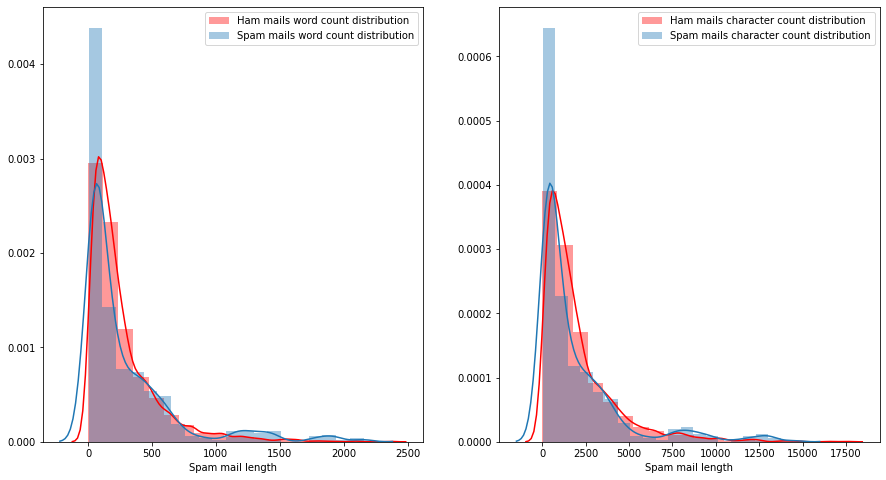

In [31]:
# add number of characters column
msg["nb_chars"] = msg["message"].apply(lambda x: len(x))

# add number of words column
msg["nb_words"] = msg["message"].apply(lambda x: len(x.split(" ")))

f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(msg[msg['label']==0]['nb_words'],bins=20,ax=ax[0],label='Ham mails word count distribution',color='r')
ax[0].set_xlabel('Ham mail length')
ax[0].legend()

sns.distplot(msg[msg['label']==1]['nb_words'],bins=20,ax=ax[0],label='Spam mails word count distribution')
ax[0].set_xlabel('Spam mail length')
ax[0].legend()

sns.distplot(msg[msg['label']==0]['nb_chars'],bins=20,ax=ax[1],label='Ham mails character count distribution',color='r')
ax[1].set_xlabel('Ham mail char length')
ax[1].legend()

sns.distplot(msg[msg['label']==1]['nb_chars'],bins=20,ax=ax[1],label='Spam mails character count distribution')
ax[1].set_xlabel('Spam mail length')
ax[1].legend()

plt.show()

 ***Word and character count were not considered as a feature since they have similar distribution for both ham and spam mails.***

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def feature_engineering(column):
  from sklearn.feature_extraction.text import TfidfVectorizer
  from nltk.sentiment.vader import SentimentIntensityAnalyzer

  sid = SentimentIntensityAnalyzer()
  tf_vec = TfidfVectorizer()

  feature = tf_vec.fit_transform(column)
  t = {}
  train_data = pd.DataFrame(t)
  train_data["sentiments"] = column.apply(lambda x: sid.polarity_scores(x))
  train_data = pd.concat([train_data.drop(['sentiments'], axis=1), train_data['sentiments'].apply(pd.Series)], axis=1)

  from scipy.sparse import hstack
  featuresfinal = hstack((feature,np.array(train_data['compound'])[:,None]))

  return featuresfinal



In [88]:
f1 = feature_engineering(msg['subject'])
f2 = feature_engineering(msg['message'])



In [89]:
from scipy.sparse import hstack
featuresfinal = hstack((f1,np.array(f2).all()))

In [90]:
featuresfinal

<2893x51830 sparse matrix of type '<class 'numpy.float64'>'
	with 485807 stored elements in COOrdinate format>

# **Data Visualisation**

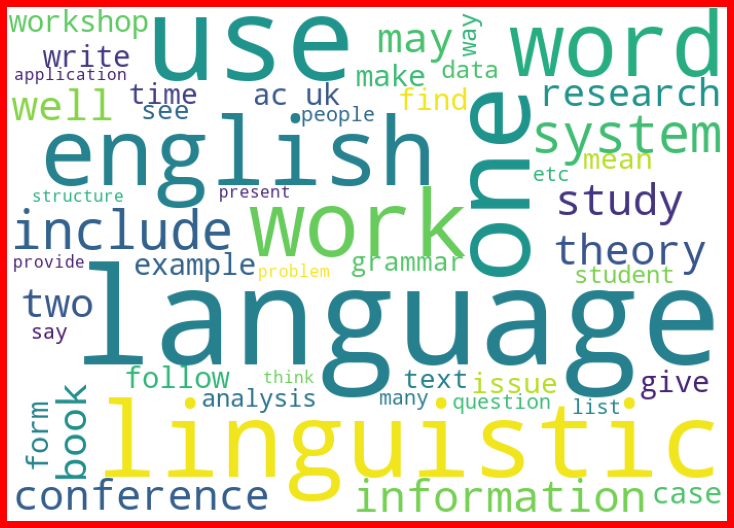

In [65]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud

ham = msg['message'][msg['label']==0]

ham_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(ham))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(ham_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

spam = msg['message'][msg['label']==1]



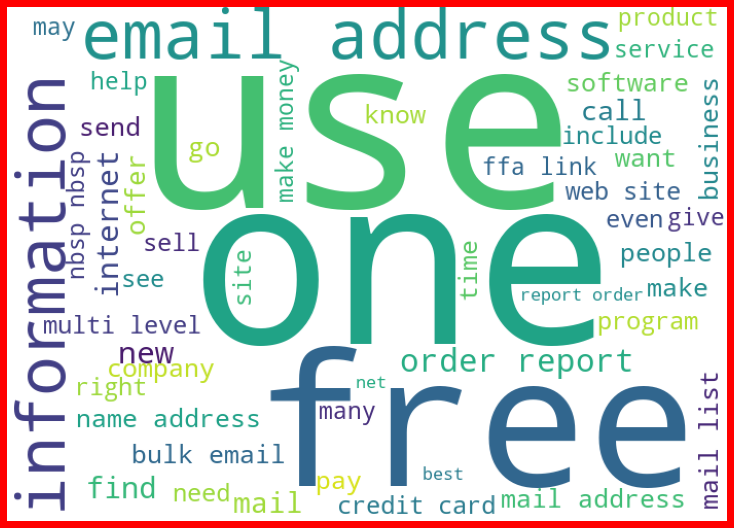

In [66]:
spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(spam))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Model**

In [67]:
features_train, features_test, labels_train, labels_test = train_test_split(featuresfinal, msg['label'], test_size=0.3, random_state=100)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [91]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
#mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=100)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=100)
abc = AdaBoostClassifier(n_estimators=62, random_state=100)
bc = BaggingClassifier(n_estimators=9, random_state=100)
etc = ExtraTreesClassifier(n_estimators=9, random_state=100)


clfs = {'SVC' : svc,'KN' : knc, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

In [92]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

def predict_labels(clf, features):
    return (clf.predict(features))

In [99]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))



In [100]:

Score_sheet = pd.DataFrame(pred_scores)
Score_sheet

,0,1
0,SVC,[0.9400921658986175]
1,KN,[0.9493087557603687]
2,DT,[0.9527649769585254]
3,LR,[0.9585253456221198]
4,RF,[0.9711981566820277]
5,AdaBoost,[0.9873271889400922]
6,BgC,[0.9619815668202765]
7,ETC,[0.966589861751152]


In [102]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9082701387895264

In [104]:
print(confusion_matrix(labels_test,pred))
print("test classification report:")
print(classification_report(labels_test,pred))

#print("train classification report:")
#print(classification_report(labels_train,lr_pred_train))

NameError: ignored

Text(0.5, 0, 'False Positive Rate')

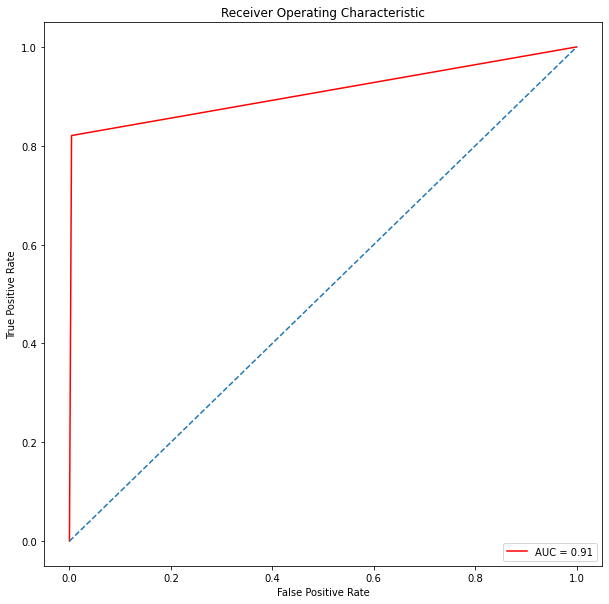

In [103]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')